In [2]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.CIFAR10(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.CIFAR10(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

100%|██████████| 170M/170M [00:07<00:00, 24.0MB/s] 


In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CIFAR10Dataset(Dataset):
    def __init__(self, images, targets, device='cpu'):
        # Convertir les tableaux NumPy en tenseurs PyTorch
        images = torch.from_numpy(images).float() / 255.0
        targets = torch.tensor(targets, dtype=torch.long)

        # CIFAR10 : images en 3x32x32, format (N, H, W, C) -> (N, C, H, W)
        images = images.permute(0, 3, 1, 2)

        self.x = images
        self.y = targets
        self.device = device

    def __getitem__(self, ix):
        x = self.x[ix].to(self.device)
        y = self.y[ix].to(self.device)
        return x, y

    def __len__(self):
        return len(self.x)


In [ ]:
def get_model(device='cpu'):
    
    model = nn.Sequential(
        # Bloc 1 (ancien Bloc 2)
        nn.Conv2d(3, 64, kernel_size=5, padding=2, bias=True),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 64, kernel_size=5, padding=2, bias=True),
        nn.ReLU(),
        nn.Dropout2d(0.25),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),  # 32x32 → 16x16

        # Bloc 2 (ancien Bloc 3)
        nn.Conv2d(64, 128, kernel_size=5, padding=2, bias=True),
        nn.ReLU(),
        nn.Dropout2d(0.25),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),  # 16x16 → 8x8

        # Bloc 3 (ancien Bloc 4)
        nn.Conv2d(128, 128, kernel_size=5, padding=2, bias=True),
        nn.ReLU(),
        nn.Dropout2d(0.25),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),  # 8x8 → 4x4

        # Classificateur
        nn.Flatten(),              # 128 * 4 * 4 = 2048
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(512, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return model, loss_fn, optimizer

In [6]:
def get_data():
    train = CIFAR10Dataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = CIFAR10Dataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [8]:
# Définir le device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Charger les données
trn_dl, val_dl = get_data()

# Initialiser le modèle
model, loss_fn, optimizer = get_model(device=device)

# Afficher un résumé du modèle
from torchsummary import summary
summary(model, (3, 32, 32))  # CIFAR10 : 3 canaux, 32x32


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]         102,464
              ReLU-5           [-1, 64, 32, 32]               0
         Dropout2d-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         204,928
             ReLU-10          [-1, 128, 16, 16]               0
        Dropout2d-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
        MaxPool2d-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 12

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [10]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [11]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(6):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4
5


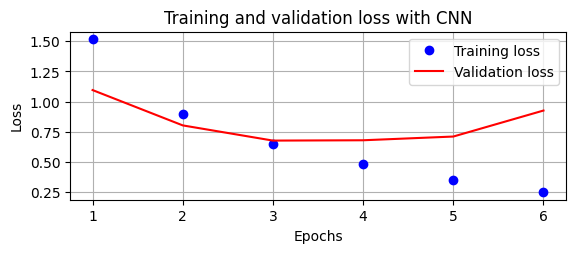

C:\Users\chali\AppData\Local\Temp\ipykernel_17972\1865961061.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


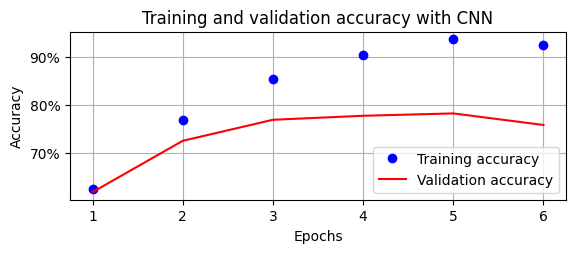

In [12]:
epochs = np.arange(6)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # nécessaire pour 3D
import numpy as np
import torch

def plot_conv_filter_3d(conv_layer, filter_index=0, channel_index=0):
    """
    Affiche un filtre convolutionnel en 3D.

    conv_layer : nn.Conv2d
    filter_index : numéro du filtre à afficher (0 ≤ filter_index < out_channels)
    channel_index : canal du filtre à afficher (0 ≤ channel_index < in_channels)
    """
    W = conv_layer.weight.data.cpu().numpy()
    filter_weights = W[filter_index, channel_index]  # shape (kernel_h, kernel_w)

    h, w = filter_weights.shape
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    Z = filter_weights

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='bwr', edgecolor='k', linewidth=0.5)
    ax.set_title(f'Filtre {filter_index}, Canal {channel_index}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Poids')
    plt.show()




In [3]:

plot_conv_filter_3d(model[8], filter_index=8, channel_index=2)

NameError: name 'model' is not defined

In [201]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from scipy.interpolate import RegularGridInterpolator

def graphcut_filter_surface(Zsmooth, percentile=70):
    """
    Simule un GraphCut sur une surface lisse en utilisant un seuil basé sur percentile.
    Zsmooth : surface lissée (2D numpy array)
    percentile : pourcentage de poids à conserver
    """
    threshold = np.percentile(np.abs(Zsmooth), percentile)
    mask = np.abs(Zsmooth) >= threshold
    Zcut = Zsmooth * mask
    return Zcut, mask

def plot_conv_surface_with_graphcut(conv_layer, filter_index=0, channel_index=0, smooth_factor=50, percentile=70):
    W = conv_layer.weight.data.cpu().numpy()
    filter_weights = W[filter_index, channel_index]

    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)

    # Interpolation lisse
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    

    # GraphCut simplifié
    Zcut, mask = graphcut_filter_surface(Zsmooth, percentile=percentile)

    # Affichage 3D
    fig = plt.figure(figsize=(12,5))

    # Surface lisse
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Zsmooth, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax1.set_title(f'Filtre {filter_index} Lissé')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Poids')

    # Surface après GraphCut
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, Zcut, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax2.set_title(f'Filtre {filter_index} après GraphCut ({percentile}%)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Poids')

    plt.show()
    return Zcut, Zsmooth, mask

# Exemple d'utilisation
#conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
# Par exemple, la 2ème couche Conv2d
#conv_layer = conv_layers[0]

#Zcut, mask = plot_conv_surface_with_graphcut(conv_layer, filter_index=2, channel_index=0, smooth_factor=50, percentile=90)


In [1]:
Zcut, Zsmooth, mask = plot_conv_surface_with_graphcut(model[0], filter_index=2, channel_index=0, smooth_factor=60, percentile=60)

NameError: name 'plot_conv_surface_with_graphcut' is not defined

In [111]:
import numpy as np

import numpy as np

def project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='max'):
    """
    Projette une surface Zcut + mask sur une grille kernel_size x kernel_size
    en gardant la valeur maximale ou moyenne des zones conservées dans chaque bloc.

    Zcut : surface lissée après GraphCut (2D numpy array)
    mask : masque booléen correspondant aux zones conservées (même taille que Zcut)
    kernel_size : taille de la grille cible (ex: 5 pour 5x5)
    method : 'max' ou 'mean' pour résumer chaque bloc

    Retour : kernel_values 5x5 avec 0 pour les zones à supprimer et la valeur projetée ailleurs
    """
    assert Zcut.shape == mask.shape, "Zcut et mask doivent avoir la même taille"

    h_smooth, w_smooth = Zcut.shape
    block_h = h_smooth // kernel_size
    block_w = w_smooth // kernel_size
    kernel_values = np.zeros((kernel_size, kernel_size))

    for i in range(kernel_size):
        for j in range(kernel_size):
            block = Zcut[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            block_mask = mask[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            block_filtered = block * block_mask  # met à zéro les zones faibles

            if method == 'max':
                kernel_values[i,j] = np.max(block_filtered)
            elif method == 'mean':
                # on prend la moyenne des valeurs non nulles
                values = block_filtered[block_filtered != 0]
                kernel_values[i,j] = np.mean(values) if len(values) > 0 else 0
            else:
                raise ValueError("method doit être 'max' ou 'mean'")

    return kernel_values


#kernel_mask_5x5 = project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='max')

# Zcut et mask obtenus après GraphCut
def show_filter(matrix_5, title="Filtre 2D"):
    """
    Affiche une matrice 5x5 (ou n×n) en 2D avec une colormap rouge/bleu.
    """
    plt.figure(figsize=(4,4))
    plt.imshow(matrix_5, cmap='bwr', interpolation='nearest')
    plt.colorbar(label='Poids')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


In [192]:
Zcut

array([[-0.        , -0.07067305, -0.08839522, ..., -0.07449451,
        -0.07609891, -0.07786503],
       [-0.        , -0.        , -0.07313223, ..., -0.07310884,
        -0.07933972, -0.08639322],
       [-0.        , -0.        , -0.        , ..., -0.07303319,
        -0.08331226, -0.09498307],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ...,  0.        ,
         0.        ,  0.        ]])

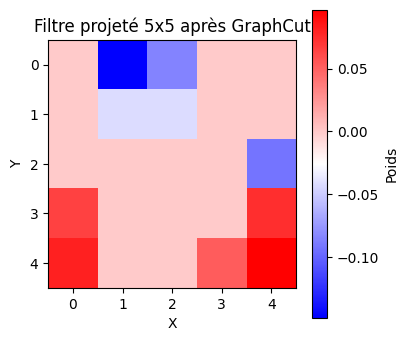

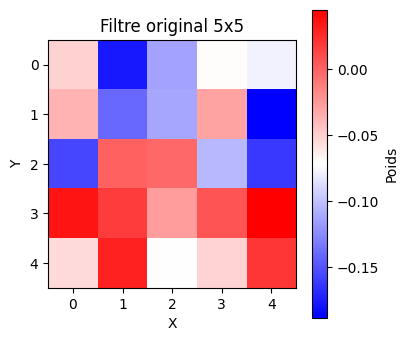

In [113]:
projected_kernel = project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='max')
show_filter(projected_kernel, title="Filtre projeté 5x5 après GraphCut")
show_filter(model[0].weight.data.cpu().numpy()[2,0], title="Filtre original 5x5")

In [190]:
import numpy as np
import torch
import torch.nn as nn
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage

def ultimate_graphcut_filter_analysis(filter_weights, method, threshold,percentile=40):
    """
    GraphCut ULTIME : Combine multi-échelle + analyse structurelle + entropie
    """
    h, w = filter_weights.shape

    # 1. Multi-échelle (3 niveaux)
    scales = [1, 2, 3]
    scale_importances = []

    for scale in scales:
        smooth_factor =  max(20, h * scale * 4)

        # Interpolation lisse
        y = np.arange(h)
        x = np.arange(w)
        interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
        ynew = np.linspace(0, h-1, smooth_factor)
        xnew = np.linspace(0, w-1, smooth_factor)
        X, Y = np.meshgrid(xnew, ynew)
        points = np.array([Y.ravel(), X.ravel()]).T
        Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)

        # 2. Analyse structurelle avancée
        # Variance locale (structure)
        local_var = ndimage.generic_filter(Zsmooth, np.var, size=3)

        # Gradient (transitions importantes)
        gy, gx = np.gradient(Zsmooth)
        gradient_mag = np.sqrt(gx**2 + gy**2)

        # Score structurel combiné
        structural_score = (0.4 * np.abs(Zsmooth) +
                           0.3 * local_var +
                           0.3 *  gradient_mag)

        # 3. Seuil adaptatif intelligent
        mean_score = np.mean(structural_score)
        std_score = np.std(structural_score)
        if(threshold == "adaptative"):
            adaptive_threshold =  mean_score + 0.6 * std_score #np.percentile(np.abs(Zsmooth),80)   # Plus intelligent que percentile fixe
        if(threshold == "fixed"):
            adaptive_threshold = np.percentile(np.abs(Zsmooth),percentile)
        # Masque des zones importantes
        if(method == "structural"):
            important_mask = structural_score >= adaptive_threshold
        if(method == "simple"):
            important_mask = np.abs(Zsmooth) >= adaptive_threshold
        Zcut = Zsmooth * important_mask

        # Projection vers taille originale
        kernel_values = project_graphcut_to_kernel_values(Zcut, important_mask, kernel_size=h, method='max')

        # Importance = énergie conservée à cette échelle
        energy_before = np.sum(np.abs(filter_weights))
        energy_after = np.sum(np.abs(kernel_values))
        scale_importance = energy_after / (energy_before + 1e-8)

        scale_importances.append(scale_importance)

    # 4. Combinaison des échelles (pondérée)
    # Les échelles fines ont plus de poids
    weights = [0.5, 0.3, 0.2]  # Plus de poids aux détails fins
    final_importance = sum(w * imp for w, imp in zip(weights, scale_importances))

    return final_importance, kernel_values

import numpy as np
import random

def contextual_redundancy_check(conv_layer, target_filter_idx, target_channel_idx, max_comparisons=15):
    """
    Vérifie la redondance contextuelle : si le filtre est similaire à d'autres, il est moins important.
    Compare aléatoirement à max_comparisons autres filtres.
    """
    W = conv_layer.weight.detach().cpu().numpy()
    target_filter = W[target_filter_idx, target_channel_idx]

    similarities = []
    out_channels, in_channels, h, w = W.shape

    # Construire la liste de tous les filtres possibles sauf le target
    all_indices = [(oc, ic) for oc in range(out_channels) for ic in range(in_channels)
                   if not (oc == target_filter_idx and ic == target_channel_idx)]

    # Tirer au hasard max_comparisons filtres
    sampled_indices = random.sample(all_indices, min(max_comparisons, len(all_indices)))

    for oc, ic in sampled_indices:
        other_filter = W[oc, ic]

        # Corrélation de Pearson
        correlation = np.corrcoef(target_filter.flatten(), other_filter.flatten())[0, 1]
        if not np.isnan(correlation):
            similarities.append(abs(correlation))

    # Pénalité de redondance
    avg_similarity = np.mean(similarities) if similarities else 0
    redundancy_penalty = max(0.5, 1.0 - avg_similarity)  # Entre 0.5 et 1.0

    return redundancy_penalty, similarities


def ultimate_graphcut_importance_measure(model):
    """
    Mesure l'importance avec GraphCut ULTIME
    """
    print("🔥 Calcul GraphCut ULTIME en cours...")

    L_ultimate = {}
    conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]

    for m_idx, conv_layer in enumerate(conv_layers):
        print(f"   Couche {m_idx+1}/{len(conv_layers)}...")
        L_ultimate[m_idx] = {}

        out_channels, in_channels, h, w = conv_layer.weight.shape

        for oc in range(out_channels):
            L_ultimate[m_idx][oc] = {}
            for ic in range(in_channels):
                # 1. Importance GraphCut multi-échelle + structurelle
                filter_weights = conv_layer.weight[oc, ic].detach().cpu().numpy()
                base_importance = ultimate_graphcut_filter_analysis(filter_weights)

                # 2. Correction contextuelle (redondance)
                redundancy_factor = contextual_redundancy_check(conv_layer, oc, ic)

                # 3. Score final
                final_importance = base_importance * redundancy_factor
                L_ultimate[m_idx][oc][ic] = float(final_importance)

    print("✅ GraphCut ULTIME terminé!")
    return L_ultimate



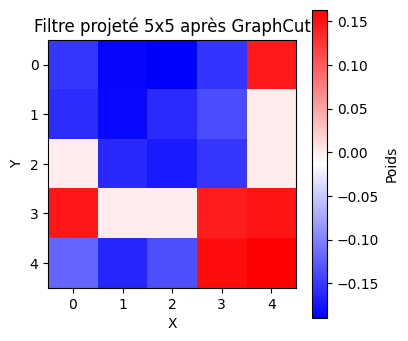

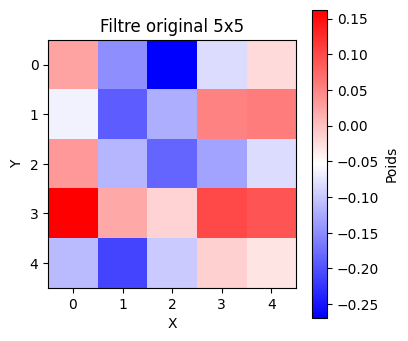

In [ ]:
final_importance, kernel_value = ultimate_graphcut_filter_analysis(model[8].weight.data.cpu().numpy()[0,0], method="structural", threshold="adaptative")
show_filter(kernel_value, title="Filtre projeté 5x5 après GraphCut")
show_filter(model[8].weight.data.cpu().numpy()[0,0], title="Filtre original 5x5")
k

In [191]:
model[8].weight.data.cpu().numpy()[0,0]

array([[ 0.02439906, -0.14774486, -0.26901716, -0.08239703, -0.02134323],
       [-0.06463236, -0.19133082, -0.12083958,  0.05277538,  0.0563964 ],
       [ 0.0339999 , -0.11513419, -0.18441156, -0.13106574, -0.08351411],
       [ 0.16250205,  0.02085505, -0.0163816 ,  0.09919927,  0.09063622],
       [-0.11129033, -0.21099295, -0.09787389, -0.01417794, -0.02989437]],
      dtype=float32)

In [24]:
import torch
import torch.nn as nn
from torch.optim import Adam  # <-- Ajout de l'import

In [25]:
import torch
import torch.nn as nn
import copy
from collections import defaultdict
import numpy as np

def prune_model_by_filters_removal(model, top_indices_list, input_size=(3, 32, 32)):
    """
    VERSION CORRIGÉE: Supprime réellement les filtres pour réduire les paramètres.

    Args:
        model: modèle PyTorch nn.Sequential
        top_indices_list: [(layer_idx, out_ch, in_ch), ...] - filtres à CONSERVER
        input_size: taille d'entrée (channels, height, width)

    Returns:
        Modèle pruné avec moins de paramètres
    """
    device = next(model.parameters()).device
    model_copy = copy.deepcopy(model)

    # Organiser les filtres à conserver par couche
    filters_to_keep = defaultdict(set)
    for layer_idx, out_ch, in_ch in top_indices_list:
        filters_to_keep[layer_idx].add(out_ch)

    # Convertir en listes triées
    for layer_idx in filters_to_keep:
        filters_to_keep[layer_idx] = sorted(list(filters_to_keep[layer_idx]))

    new_layers = []
    conv_layers = [i for i, layer in enumerate(model_copy) if isinstance(layer, nn.Conv2d)]
    prev_kept_channels = None

    for i, layer in enumerate(model_copy):
        if isinstance(layer, nn.Conv2d):
            # Trouver l'index de cette couche conv
            conv_idx = conv_layers.index(i)

            # Déterminer les canaux de sortie à conserver
            if conv_idx in filters_to_keep:
                keep_out_channels = filters_to_keep[conv_idx]
            else:
                # Si pas spécifié, garder tous les canaux
                keep_out_channels = list(range(layer.out_channels))

            # Déterminer les canaux d'entrée
            if conv_idx == 0:
                # Première couche: garder tous les canaux d'entrée (RGB)
                new_in_channels = layer.in_channels
                keep_in_channels = list(range(layer.in_channels))
            else:
                # Couches suivantes: s'adapter aux canaux conservés de la couche précédente
                new_in_channels = len(prev_kept_channels) if prev_kept_channels else layer.in_channels
                keep_in_channels = prev_kept_channels if prev_kept_channels else list(range(layer.in_channels))

            new_out_channels = len(keep_out_channels)

            # Créer la nouvelle couche Conv2d RÉDUITE
            new_conv = nn.Conv2d(
                in_channels=new_in_channels,
                out_channels=new_out_channels,
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
                bias=(layer.bias is not None)
            ).to(device)

            # Copier uniquement les poids des filtres conservés
            with torch.no_grad():
                for new_out_idx, old_out_idx in enumerate(keep_out_channels):
                    for new_in_idx, old_in_idx in enumerate(keep_in_channels):
                        new_conv.weight[new_out_idx, new_in_idx] = layer.weight[old_out_idx, old_in_idx]

                    if layer.bias is not None:
                        new_conv.bias[new_out_idx] = layer.bias[old_out_idx]

            new_layers.append(new_conv)
            prev_kept_channels = keep_out_channels

        elif isinstance(layer, nn.BatchNorm2d):
            # Adapter BatchNorm aux canaux conservés
            if prev_kept_channels is not None:
                new_bn = nn.BatchNorm2d(len(prev_kept_channels)).to(device)
                with torch.no_grad():
                    for new_idx, old_idx in enumerate(prev_kept_channels):
                        new_bn.weight[new_idx] = layer.weight[old_idx]
                        new_bn.bias[new_idx] = layer.bias[old_idx]
                        new_bn.running_mean[new_idx] = layer.running_mean[old_idx]
                        new_bn.running_var[new_idx] = layer.running_var[old_idx]
                new_layers.append(new_bn)
            else:
                new_layers.append(copy.deepcopy(layer))

        elif isinstance(layer, nn.Linear):
            # Ajuster la première couche Linear après Flatten
            if len([l for l in new_layers if isinstance(l, nn.Linear)]) == 0:
                # Calculer la nouvelle taille après les couches conv
                new_input_features = calculate_linear_input_size(new_layers, input_size)

                new_linear = nn.Linear(
                    in_features=new_input_features,
                    out_features=layer.out_features,
                    bias=(layer.bias is not None)
                ).to(device)

                # Copier les poids (avec adaptation de taille)
                with torch.no_grad():
                    min_features = min(new_input_features, layer.in_features)
                    new_linear.weight[:, :min_features] = layer.weight[:, :min_features]
                    if layer.bias is not None:
                        new_linear.bias[:] = layer.bias[:]

                new_layers.append(new_linear)
            else:
                # Autres couches Linear: copier tel quel
                new_layers.append(copy.deepcopy(layer))
        else:
            # Autres couches (ReLU, MaxPool, Dropout, Flatten)
            new_layers.append(copy.deepcopy(layer))

    return nn.Sequential(*new_layers).to(device)

def calculate_linear_input_size(conv_layers, input_size):
    """
    Calcule la taille d'entrée pour la première couche Linear
    en simulant une passe avant à travers les couches conv.
    """
    channels, h, w = input_size

    for layer in conv_layers:
        if isinstance(layer, nn.Conv2d):
            # Calculer nouvelle taille après convolution
            kernel_size = layer.kernel_size[0] if isinstance(layer.kernel_size, tuple) else layer.kernel_size
            stride = layer.stride[0] if isinstance(layer.stride, tuple) else layer.stride
            padding = layer.padding[0] if isinstance(layer.padding, tuple) else layer.padding

            h = (h + 2*padding - kernel_size) // stride + 1
            w = (w + 2*padding - kernel_size) // stride + 1
            channels = layer.out_channels

        elif isinstance(layer, nn.MaxPool2d):
            kernel_size = layer.kernel_size
            stride = layer.stride if layer.stride else kernel_size
            h = h // stride
            w = w // stride

    return channels * h * w

def structured_channel_pruning(model, importance_dict, keep_ratio=0.5):
    """
    Pruning structuré: supprime des canaux entiers basé sur leur importance moyenne.
    Plus efficace pour réduire réellement les paramètres.

    Args:
        model: modèle à pruner
        importance_dict: dict[layer][out_ch][in_ch] = importance
        keep_ratio: fraction de canaux à conserver (0.5 = 50%)
    """
    # Calculer l'importance moyenne par canal de sortie
    channel_importance = {}

    for layer_idx in importance_dict:
        channel_importance[layer_idx] = {}
        for out_ch in importance_dict[layer_idx]:
            # Moyenne d'importance sur tous les canaux d'entrée pour ce canal de sortie
            avg_importance = np.mean(list(importance_dict[layer_idx][out_ch].values()))
            channel_importance[layer_idx][out_ch] = avg_importance

    # Sélectionner les top canaux pour chaque couche
    top_indices = []
    for layer_idx in channel_importance:
        # Trier par importance décroissante
        channels_by_importance = sorted(
            channel_importance[layer_idx].items(),
            key=lambda x: x[1],
            reverse=True
        )

        # Garder le top keep_ratio
        n_keep = max(1, int(len(channels_by_importance) * keep_ratio))
        top_channels = [ch for ch, _ in channels_by_importance[:n_keep]]

        # Créer les indices pour tous les canaux d'entrée de ces canaux de sortie
        for out_ch in top_channels:
            for in_ch in importance_dict[layer_idx][out_ch]:
                top_indices.append((layer_idx, out_ch, in_ch))

    return top_indices

def test_effective_pruning(model, importance_dict, trn_dl, val_dl, loss_fn, keep_ratios=[0.8, 0.6, 0.4, 0.2]):
    """
    Test de pruning avec réduction EFFECTIVE des paramètres.
    """
    print("Test de Pruning avec Réduction Effective des Paramètres")
    print("="*60)

    # Baseline
    orig_params = sum(p.numel() for p in model.parameters())
    orig_loss, orig_acc = evaluate_model(model, val_dl, loss_fn)

    print(f"Modèle original: {orig_acc:.4f} accuracy, {orig_params:,} paramètres")
    print()

    results = []

    for keep_ratio in keep_ratios:
        print(f"Test avec keep_ratio = {keep_ratio} ({keep_ratio*100:.0f}% des canaux)")
        print("-" * 40)

        try:
            # Pruning structuré par canaux
            top_indices = structured_channel_pruning(model, importance_dict, keep_ratio)
            print(f"Filtres sélectionnés: {len(top_indices)}")

            # Appliquer le pruning EFFECTIF
            pruned_model = prune_model_by_filters_removal(model, top_indices, input_size=(3, 32, 32))

            # Vérifier la réduction
            pruned_params = sum(p.numel() for p in pruned_model.parameters())
            actual_reduction = (orig_params - pruned_params) / orig_params * 100

            print(f"Paramètres avant: {orig_params:,}")
            print(f"Paramètres après: {pruned_params:,}")
            print(f"Réduction RÉELLE: {actual_reduction:.1f}%")

            # Test du modèle pruné
            val_loss_before, val_acc_before = evaluate_model(pruned_model, val_dl, loss_fn)
            print(f"Accuracy avant fine-tuning: {val_acc_before:.4f}")

            # Fine-tuning
            print("Fine-tuning...")
            pruned_model = fine_tune_pruned_model(pruned_model, trn_dl, val_dl, loss_fn, epochs=5, lr=1e-3)

            val_loss_final, val_acc_final = evaluate_model(pruned_model, val_dl, loss_fn)

            accuracy_retention = (val_acc_final / orig_acc) * 100
            compression_ratio = orig_params / pruned_params

            print(f"Accuracy finale: {val_acc_final:.4f}")
            print(f"Rétention accuracy: {accuracy_retention:.1f}%")
            print(f"Ratio de compression: {compression_ratio:.1f}x")
            print()

            results.append({
                'keep_ratio': keep_ratio,
                'actual_reduction': actual_reduction,
                'final_accuracy': val_acc_final,
                'accuracy_retention': accuracy_retention,
                'compression_ratio': compression_ratio,
                'pruned_params': pruned_params
            })

        except Exception as e:
            print(f"Erreur avec keep_ratio {keep_ratio}: {e}")
            print()

    # Résumé des résultats
    print("RÉSUMÉ DES RÉSULTATS")
    print("="*40)
    for r in results:
        print(f"Keep {r['keep_ratio']*100:.0f}%: {r['actual_reduction']:.1f}% réduction, "
              f"{r['accuracy_retention']:.1f}% accuracy, {r['compression_ratio']:.1f}x compression")

    return results

# Fonction d'évaluation (si pas déjà définie)
def evaluate_model(model, val_dl, loss_fn):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in val_dl:
            device = next(model.parameters()).device
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss += loss_fn(pred, y).item() * x.size(0)
            total_correct += (pred.argmax(1) == y).sum().item()
            total_samples += x.size(0)

    return total_loss / total_samples, total_correct / total_samples

def fine_tune_pruned_model(pruned_model, trn_dl, val_dl, loss_fn, epochs=3, lr=1e-4):
    """Fine-tune le modèle pruné pour récupérer l'accuracy."""
    from torch.optim import Adam

    device = next(pruned_model.parameters()).device
    optimizer = Adam(pruned_model.parameters(), lr=lr)

    for epoch in range(epochs):
        pruned_model.train()
        for x, y in trn_dl:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = pruned_model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

        # Validation check
        val_loss, val_acc = evaluate_model(pruned_model, val_dl, loss_fn)
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print(f"  Epoch {epoch+1}: Val Acc = {val_acc:.4f}")

    return pruned_model

# Usage example:
# Remplacer votre appel par:


In [26]:
L_ultimate = ultimate_graphcut_importance_measure(model)

🔥 Calcul GraphCut ULTIME en cours...
   Couche 1/4...
   Couche 2/4...
   Couche 3/4...
   Couche 4/4...
✅ GraphCut ULTIME terminé!


In [27]:
import copy

model_copy = copy.deepcopy(model)

In [28]:
results = test_effective_pruning(model_copy, L_ultimate, trn_dl, val_dl, loss_fn)

Test de Pruning avec Réduction Effective des Paramètres
Modèle original: 0.7584 accuracy, 3,350,858 paramètres

Test avec keep_ratio = 0.8 (80% des canaux)
----------------------------------------
Filtres sélectionnés: 23001
Paramètres avant: 3,350,858
Paramètres après: 2,662,040
Réduction RÉELLE: 20.6%
Accuracy avant fine-tuning: 0.1459
Fine-tuning...
  Epoch 1: Val Acc = 0.7184
  Epoch 2: Val Acc = 0.7524
  Epoch 4: Val Acc = 0.7732
Accuracy finale: 0.7773
Rétention accuracy: 102.5%
Ratio de compression: 1.3x

Test avec keep_ratio = 0.6 (60% des canaux)
----------------------------------------
Filtres sélectionnés: 17138
Paramètres avant: 3,350,858
Paramètres après: 2,032,372
Réduction RÉELLE: 39.3%
Accuracy avant fine-tuning: 0.0811
Fine-tuning...
  Epoch 1: Val Acc = 0.6863
  Epoch 2: Val Acc = 0.7224
  Epoch 4: Val Acc = 0.7593
Accuracy finale: 0.7574
Rétention accuracy: 99.9%
Ratio de compression: 1.6x

Test avec keep_ratio = 0.4 (40% des canaux)
---------------------------------

In [29]:
summary(model, (3, 32, 32))  # CIFAR10 : 3 canaux, 32x32

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]         102,464
              ReLU-5           [-1, 64, 32, 32]               0
         Dropout2d-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         204,928
             ReLU-10          [-1, 128, 16, 16]               0
        Dropout2d-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
        MaxPool2d-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 12